In [1]:
import numpy as np
import os, h5py
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import linecache
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import scipy.stats as ss
import matplotlib.pyplot as plt

from varcode import Variant
from pyensembl import ensembl_grch38

In [2]:
import tensorflow_datasets as tfds
def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    xs = []
    ys = []
    coords = []

    # Iterate over a dataset
    for i, (x, y, coord) in enumerate(tfds.as_numpy(ds)):
        xs.append(x)
        ys.append(y)
        coords.append(coord)


    return np.array(xs), np.array(ys), np.array(coords)

In [3]:
def load_test_data(file, window_size=11, remove_AF = False, AF_free_model = False):
     """
     Load tfrecord data and output a tensorflow Dataset
     """
     n_features = 28
     raw_dataset = tf.data.TFRecordDataset(file)
     feature_description = {
                         'x': tf.io.FixedLenFeature([window_size*n_features], tf.float32, default_value=tf.zeros(window_size*n_features)),
                         'y': tf.io.FixedLenFeature([1], tf.float32, default_value=tf.zeros(1)),
                         'coord': tf.io.FixedLenFeature([1], tf.string, default_value='')
                         }
                         
     @tf.autograph.experimental.do_not_convert
     def reshape_and_window(x, remove_AF = remove_AF, AF_free_model = AF_free_model):
          if AF_free_model:
               anno_scores = tf.reshape(x['x'], (window_size, n_features))[:,:-4]
               return tf.squeeze(anno_scores), x['y'], x['coord']
          else:
               if remove_AF:
                    anno_scores = [tf.reshape(x['x'], (window_size, n_features))[:,:-4]]
                    af_scores = [tf.zeros((window_size,4))]
                    return tf.concat(anno_scores+af_scores, axis=-1), x['y'], x['coord']
               
               else:
                    return tf.reshape(x['x'], (window_size, n_features)), x['y'], x['coord']
          

     @tf.function
     def _parse_function(example_proto):
          # Parse the input `tf.train.Example` proto using the dictionary above.
          return tf.io.parse_single_example(example_proto, feature_description)

     return raw_dataset.map(_parse_function).map(reshape_and_window)


def ROCPlot(cand_prediction,MetaRNN_label,other_scores,legend_size = 15, fig_size = (20, 20), linewidth = 10, with_coord = True):
    '''
    Plot ROC curves with cand_prediction showing on top and rank other_scores based on their AUC.
    scores are pandas dataframes.
    
    '''
    fpr_candidate,tpr_candidate,_ = metrics.roc_curve(MetaRNN_label,cand_prediction)
    auc_candidate = metrics.roc_auc_score(MetaRNN_label,cand_prediction)
    names = ['MetaRNN']
    fpr = [fpr_candidate]
    tpr = [tpr_candidate]
    auc = [auc_candidate]
    if with_coord:
         other_scores = other_scores.iloc[:,6:]
    
    for colName, colData in other_scores.iloc[:,:-1].iteritems():
        colData = colData.astype(np.float32)
        na_idx = - (colData.isna())
        y_test = other_scores['label'][na_idx]
        y_pred = colData[na_idx].values
        fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred)
        auc1 = metrics.roc_auc_score(y_test, y_pred)
        fpr.append(fpr1)
        tpr.append(tpr1)
        auc.append(auc1)
        colName = colName.replace('_rankscore','').replace('_converted','').replace('_raw','')
        names.append(colName)
    index = ss.rankdata(auc)
    index = len(auc) - index   # Reverse rank so the highest AUC shows at the begninning
    index = [int(x) for x in index]
    print(auc)
    fig = plt.figure(figsize=fig_size)

    plt.plot(fpr[0],tpr[0],label="{}, AUC={:.4f}".format(names[0], auc[0]),color= 'red', linewidth=linewidth)

    for i in range(1,len(index)):
          new_index = index.index(i)
          # if i==0:
          #      plt.plot(fpr[new_index],tpr[new_index],label="{}, AUC={:.4f}".format(names[new_index], auc[new_index]), color='red', linewidth=linewidth)
          # else:
          plt.plot(fpr[new_index],tpr[new_index],label="{}, AUC={:.4f}".format(names[new_index], auc[new_index]), linewidth=linewidth)

    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(prop={'size': legend_size})
    plt.tight_layout
    return fig
     
def PRCPlot(cand_prediction,MetaRNN_label,other_scores,legend_size = 15, fig_size = (20, 20), linewidth = 10, with_coord = True):
    '''
    Plot PR curves with cand_prediction showing on top and rank other_scores based on their AUC.
    scores are pandas dataframes.
    
    '''
    p1, r1, _= metrics.precision_recall_curve(MetaRNN_label,cand_prediction)
    pr1 = metrics.average_precision_score(MetaRNN_label,cand_prediction)
    names = ['MetaRNN']
    p = [p1]
    r = [r1]
    pr = [pr1]
    if with_coord:
         other_scores = other_scores.iloc[:,6:]
    
    for colName, colData in other_scores.iteritems():
        colData = colData.astype('float')
        na_idx = - (colData.isna())
        y_test = MetaRNN_label[na_idx]
        y_pred = colData[na_idx].values
        p1, r1, _ = metrics.precision_recall_curve(y_test,  y_pred)
        pr1 = metrics.average_precision_score(y_test, y_pred)
        p.append(p1)
        r.append(r1)
        pr.append(pr1)
        colName = colName.replace('_rankscore','').replace('_converted','').replace('_raw','')
        names.append(colName)
    index = ss.rankdata(pr)
    index = len(pr) - index   # Reverse rank so the highest AUC shows at the begninning
    index = [int(x) for x in index]
    fig = plt.figure(figsize=fig_size)

#     plt.plot(fpr[0],tpr[0],label="{}, AUC={:.4f}".format(names[0], auc[0]),color= 'red', linewidth=linewidth)

    for i in range(len(index)):
          new_index = index.index(i)
          if i==0:
               plt.plot(r[new_index],p[new_index],label="{}, AP={:.4f}".format(names[new_index], pr[new_index]), color='red', linewidth=linewidth)
          else:
               plt.plot(r[new_index],p[new_index],label="{}, AP={:.4f}".format(names[new_index], pr[new_index]), linewidth=linewidth)

    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(prop={'size': legend_size})
    plt.tight_layout
    return fig

In [5]:
# model = tf.keras.models.load_model('GRU_adam_16_256_SNV_AllowOnlyDense/RNN_DNN_adam_GRU_0.h5')
batch_size =16
ts_matched = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
# model.evaluate(ts_nolimit)
MetaRNN_pred = model.predict(ts_matched.batch(batch_size)).flatten()
# label = np.array([y.numpy()[0] for x,y,coords in ts_nolimit])

## Mutation bias in AA

In [203]:
fp = []
tp = []
fn = []
tn = []
label = y.flatten()
for i,j in enumerate(MetaRNN_pred):
     if j>=0.5 and label[i]==0:
          fp.append(coords[i])
     elif j<0.5 and label[i]==1:
          fn.append(coords[i])
     elif j<0.5 and label[i]==0:
          tn.append(coords[i])
     elif j>=0.5 and label[i]==1:
          tp.append(coords[i])


In [204]:
fp_ref = [x.split('_')[4] for x in fp]
fp_alt = [x.split('_')[5] for x in fp]

fn_ref = [x.split('_')[4] for x in fn]
fn_alt = [x.split('_')[5] for x in fn]

tp_ref = [x.split('_')[4] for x in tp]
tp_alt = [x.split('_')[5] for x in tp]

tn_ref = [x.split('_')[4] for x in tn]
tn_alt = [x.split('_')[5] for x in tn]


In [205]:
AA_ALL = set(tp_ref)
AA_dict = {k:v for k,v in zip(AA_ALL,range(20))}

In [206]:
import seaborn as sns
def aa_mutation_plot(aa_ref, aa_alt, figsize=(10,10)):
     """
     return mutation matrix and plot.
     Selenocysteine(U) will be ignored.
     """
     aa_mat = np.zeros((20,20),dtype='int32')
     for i,j in enumerate(aa_ref):
          try:
               aa_mat[AA_dict[aa_alt[i]],AA_dict[j]] += 1
          except KeyError:
               print('warning: unexpected amino acid ignored')
               continue
     _, ax = plt.subplots(figsize=figsize)
     p = sns.heatmap(aa_mat, linewidth=0.5, xticklabels=AA_ALL, yticklabels=AA_ALL, annot=True,linewidths=.5,ax=ax,fmt='d')
     p.set_xlabel('Reference amino acids', fontsize=20)
     p.set_ylabel('Alternative amino acids', fontsize=20)
     return aa_mat, p

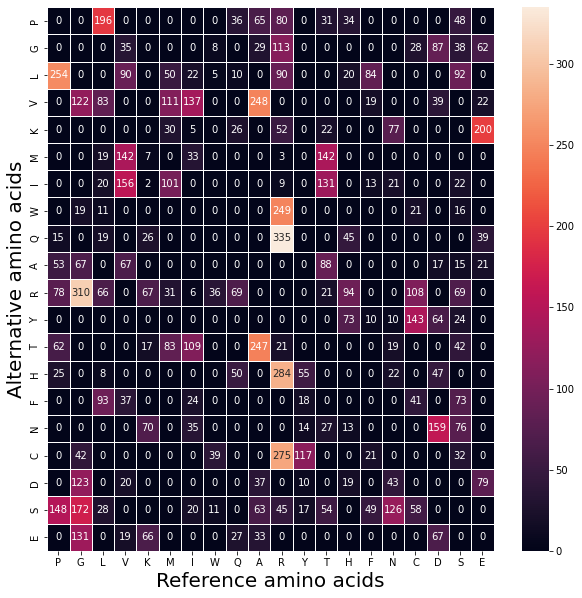

In [207]:
correct_mat,b = aa_mutation_plot(tp_ref+tn_ref, tp_alt+tn_alt)
b.get_figure().savefig('correct_aa_change.pdf')

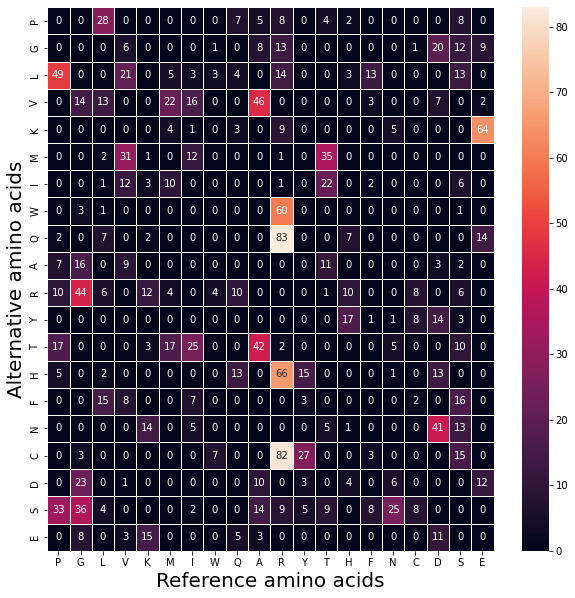

In [208]:
wrong_mat,b = aa_mutation_plot(fp_ref+fn_ref, fp_alt+fn_alt)
b.get_figure().savefig('wrong_aa_change.pdf')

In [209]:
# 4.52x10-6 for R->C mutation. More R to C mutation was observed in those wrongly predicted instances.
correct_sum = np.sum(correct_mat)
wrong_sum = np.sum(wrong_mat)
for ref in range(20):
     for alt in range(20):
          correct_item = correct_mat[alt, ref]
          wrong_item = wrong_mat[alt, ref]
          try:
               chi2, p, dof, ex = ss.chi2_contingency(np.array([[correct_item, correct_sum-correct_item], [wrong_item, wrong_sum-wrong_item]]))
               if p < 0.001:
                    print(p, alt, ref)
          except:
               continue

4.631557065434958e-05 16 10
0.000968575081418983 11 16
5.150443642778281e-05 4 19


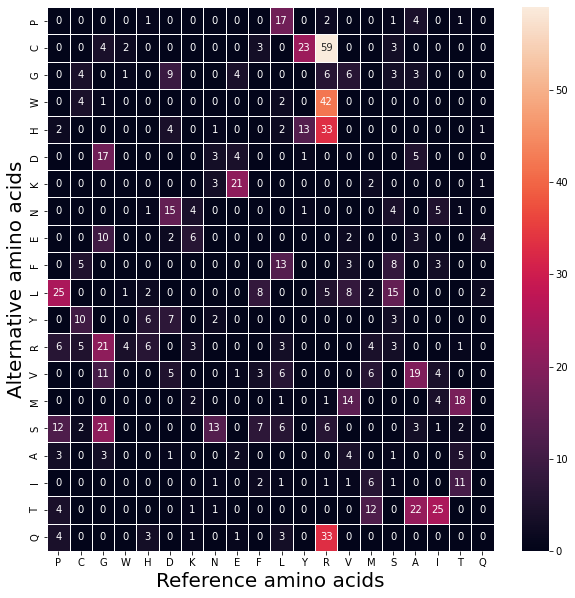

In [121]:
a,b = aa_mutation_plot(fp_ref, fp_alt)
b.get_figure().savefig('fp_aa_change.pdf')

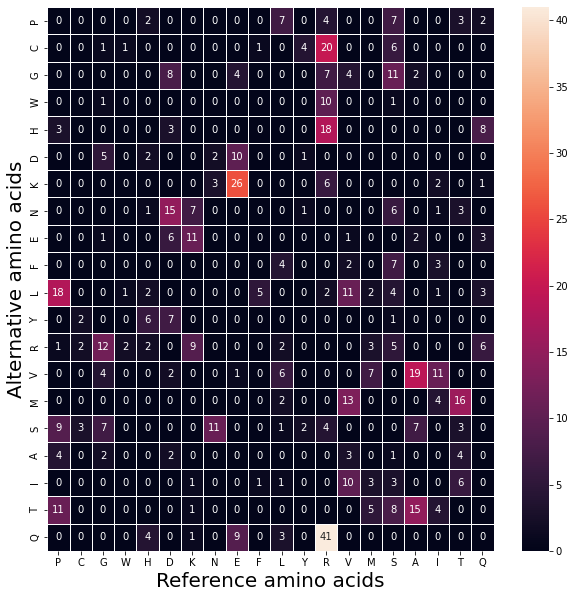

In [140]:
a,b = aa_mutation_plot(fn_ref, fn_alt)
b.get_figure().savefig('fn_aa_change.pdf')

In [ ]:
ts_nolimit = load_test_data('valid.matched.6226.6226.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

## SHAP analysis of MetaRNN model

In [298]:
import shap
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

import numpy as np
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [299]:
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [300]:
ts_train = load_test_data('train.nolimit.tfrecord', remove_AF = False)
ts_valid = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)

In [301]:
train_x, train_y, train_coord = dataset_to_numpy(ts_train)
valid_x, valid_y, valid_coord = dataset_to_numpy(ts_valid)

In [306]:
train_idx = np.random.choice(train_x.shape[0], 1000)
valid_idx = np.random.choice(valid_x.shape[0], 1000)

In [307]:
e = shap.DeepExplainer(model, train_x[train_idx])

In [ ]:
shap_values = e.shap_values(valid_x, check_additivity=False)

In [14]:
shap_values_train = e.shap_values(train_x[-train_idx][:100], check_additivity=False)

In [15]:
colnames = pd.read_csv('../Colnames',header=None)
anno_cols = np.array([74,75,76,77,78,79,80,81,83,84,86,87,91,92,93,94,95,96,97,98,99,100,101,102])
colnames = [x.replace('_score','').replace('_coding','') for x in colnames[0][anno_cols]]+['1000GP', 'ExAC', 'gnomad_exome','gnomad_genome']

In [ ]:
shap.summary_plot(np.mean(shap_values[0], axis=-2).reshape(-1,28), feature_names = colnames, plot_type='bar', max_display=28, plot_size = [6,6],show=False)

In [17]:
import matplotlib.pyplot as plt

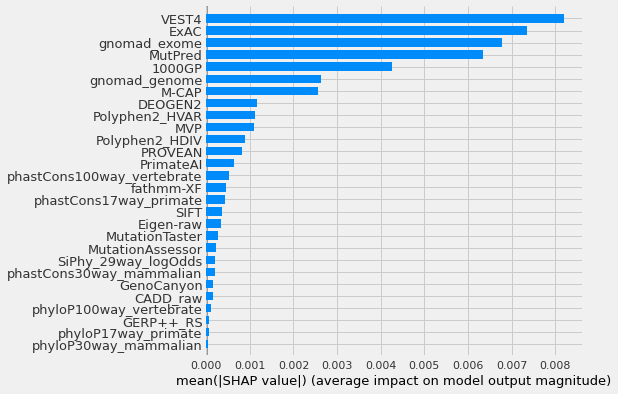

In [18]:
plt.style.use('fivethirtyeight')
shap.summary_plot(np.mean(shap_values[0], axis=-2).reshape(-1,28), feature_names = colnames, plot_type='bar', max_display=28, plot_size = [6,6],show=False)
# plt.tight_layout()
plt.savefig('SHAP_FeatureImportance.pdf',bbox_inches='tight')

## codon bias

In [4]:
import linecache

In [260]:
ts_valid = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [261]:
colnames = linecache.getline("dbNSFP_valid.tsv", 1).strip('\n').split('\t')
tp_df = pd.read_csv('valid_tp_match_ds_5770_105', sep='\t', header=None)
tn_df = pd.read_csv('valid_tn_single_ds_5770_105', sep='\t', header=None)
tp_content  = pd.DataFrame(tp_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tp_content['label'] = 1
tn_content  = pd.DataFrame(tn_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tn_content['label'] = 0
ts = pd.concat([tp_content, tn_content])
ts['pos(1-based)'].astype('int64',copy=False)
ts.replace('.',np.NaN, inplace=True)
ts = ts.astype({'pos(1-based)':'int64'})
ts_sorted = ts.sort_values(by=['#chr','pos(1-based)'])
ts["key"] = ts['#chr'].astype('str')+'_'+ts['pos(1-based)'].astype('str')+'_'+ts['ref'].astype('str')+'_'+ts['alt'].astype('str')+'_'+ts['aaref'].astype('str')+'_'+ts['aaalt'].astype('str')
linecache.clearcache()

In [262]:
x,y,coord = dataset_to_numpy(ts_valid)
coords = np.array([coord.numpy()[0].decode() for x,y,coord in ts_valid])

In [ ]:
for i,j in ts.iloc[:,6:-2].iteritems():
     idx = -j.isna()
     print(roc_auc_score(ts.loc[idx,'label'], j[idx]))

In [263]:
MetaRNN_pred = model.predict(x, batch_size = 32)
MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[x.decode() for x in coord.flatten()]}
MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)
ts_merged = ts.merge(MetaRNN_ds, on='key')
ts_merged = ts_merged.drop(['key','label'], axis=1)
# ts_merged['MetaRNN_label'] = ts_merged['MetaRNN_label'].astype('int32')


In [243]:
ts_indel = load_test_data('valid.indel.coord.tfrecord', window_size=58, remove_AF = False)

In [65]:
model = tf.keras.models.load_model('RNN_DNN_indel_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [244]:
x, y, coord = dataset_to_numpy(ts_indel)

In [246]:
coords = [x[0].decode() for x in coord]

In [84]:
MetaRNN_pred = model.predict(x, batch_size = 4)
MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[z.decode() for z in coord.flatten()]}
MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)
MetaRNN_ds['MetaRNN_label'] = MetaRNN_ds['MetaRNN_label'].astype('int32')
MetaRNN_ds['AA1'] = MetaRNN_ds['key'].apply(lambda x: True if len(x.split('_')[6])==len(x.split('_')[7])==1 else False)

In [86]:
MetaRNN_ds['AA2'] = MetaRNN_ds['key'].apply(lambda x: True if ((len(x.split('_')[6])>5) | (len(x.split('_')[7])>5)) else False)

In [92]:
aa1_roc = roc_auc_score(MetaRNN_ds.loc[MetaRNN_ds['AA1'], 'MetaRNN_label'], MetaRNN_ds.loc[MetaRNN_ds['AA1'], 'MetaRNN'])
aa2_roc = roc_auc_score(MetaRNN_ds.loc[-(MetaRNN_ds['AA2']|MetaRNN_ds['AA1']), 'MetaRNN_label'], MetaRNN_ds.loc[-(MetaRNN_ds['AA2']|MetaRNN_ds['AA1']), 'MetaRNN'])
aa3_roc = roc_auc_score(MetaRNN_ds.loc[MetaRNN_ds['AA2'], 'MetaRNN_label'], MetaRNN_ds.loc[MetaRNN_ds['AA2'], 'MetaRNN'])

In [99]:
aa1_pr = metrics.average_precision_score(MetaRNN_ds.loc[MetaRNN_ds['AA1'], 'MetaRNN_label'], MetaRNN_ds.loc[MetaRNN_ds['AA1'], 'MetaRNN'])
aa2_pr = metrics.average_precision_score(MetaRNN_ds.loc[-(MetaRNN_ds['AA2']|MetaRNN_ds['AA1']), 'MetaRNN_label'], MetaRNN_ds.loc[-(MetaRNN_ds['AA2']|MetaRNN_ds['AA1']), 'MetaRNN'])
aa3_pr = metrics.average_precision_score(MetaRNN_ds.loc[MetaRNN_ds['AA2'], 'MetaRNN_label'], MetaRNN_ds.loc[MetaRNN_ds['AA2'], 'MetaRNN'])

In [96]:
aa1_ss = sum(MetaRNN_ds['AA1'])
aa2_ss = sum(-(MetaRNN_ds['AA2']|MetaRNN_ds['AA1']))
aa3_ss = sum(MetaRNN_ds['AA2'])

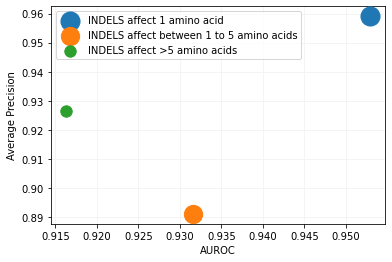

In [113]:
plt.grid(color='0.95', zorder=0)
plt.scatter([aa1_roc], [aa1_pr], s=[aa1_ss], label='INDELS affect 1 amino acid', zorder=3)
plt.scatter([aa2_roc], [aa2_pr], s=[aa2_ss], label='INDELS affect between 1 to 5 amino acids', zorder=3)
plt.scatter([aa3_roc], [aa3_pr], s=[aa3_ss], label='INDELS affect >5 amino acids', zorder=3)

plt.legend()
plt.xlabel('AUROC')
plt.ylabel('Average Precision')
plt.tight_layout
plt.savefig('INDEL_length.pdf')

In [118]:
print("Number of complex substitutions that affect only 1 amino acid:")
print(sum(MetaRNN_ds.loc[MetaRNN_ds['AA1'],'key'].apply(lambda x: True if 'X' not in x.split('_')[6:8] else False)))

Number of complex substitutions that affect only 1 amino acid:
0


### Same variants convert between SNV and INDEL (block change)

In [119]:
ts_valid = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

In [120]:
x, y, coord = dataset_to_numpy(ts_valid)

In [122]:
MetaRNN_pred = model.predict(x, batch_size = 32)
MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[x.decode() for x in coord.flatten()]}
MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)

In [161]:
def get_top_effect(contig, start, ref, alt):
     myVariant = Variant(contig=contig, start=start, ref=ref, alt=alt, ensembl=ensembl_grch38)
     me =  myVariant.effects()
     return me.top_priority_effect()

In [190]:
contig, start, ref, alt, aaref, aaalt = MetaRNN_ds['key'][1].split('_')
start = int(start)

In [ ]:
Outfile = open('MetaRNN_INDEL_SNV_MATCH.vcf','w')
Outfile.write('\t'.join(['#CHROM','POS','ID','REF','ALT','INFO'])+'\n')
count = 0
for colName, ColData in MetaRNN_ds.iterrows():
     contig, start, ref, alt, aaref, aaalt = ColData['key'].split('_')
     label = str(int(ColData['MetaRNN_label']))
     start = int(start)
     me = get_top_effect(contig, start, ref, alt)
     for _ in range(100):
          sel1 = np.random.choice([start, start-1, start-2])
          sel2 = np.random.choice(AA_TO_DNA[aaref])
          sel3 = np.random.choice(AA_TO_DNA[aaalt])
          try:
               test = get_top_effect(contig, sel1, sel2, sel3)
               if test!=me and ((len(test.variant.ref)>1) | (len(test.variant.alt)>1)):
                    Outfile.write('\t'.join([contig, str(test.variant.start), '.', test.variant.ref, test.variant.alt, str(ColData['MetaRNN'])+'_'+label])+'\n')
                    break
          except ValueError:
               continue
     count += 1
     if count %100==0:
          print(count)
Outfile.close()

In [236]:
me = myVariant.effects().top_priority_effect()
Conseq = type(me).__name__

In [245]:
me

Substitution(variant=Variant(contig='1', start=1047368, ref='GAG', alt='AAA', reference_name='GRCh38'), transcript_name=AGRN-209, transcript_id=ENST00000651234, effect_description=p.E1039K)

In [ ]:
def get_top_effect(contig, start, ref, alt):
     myVariant = Variant(contig=contig, start=start, ref=ref, alt=alt, ensembl=ensembl_grch38)
     me =  myVariant.effects()
     return me.top_priority_effect()

model = tf.keras.models.load_model('RNN_DNN_indel_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

Annotated = open('test.indel.annotated.tsv','w')
indel_var = open('MetaRNN_INDEL_SNV_MATCH.vcf','r')
indel_var_dict = {}
pre_chrom = 0
for idx,line in enumerate(indel_var):
     if line[0]!='#':
          line = line.strip('\n').split('\t')
          if pre_chrom != line[0]:
               anno_file = h5py.File('/media/changli/extradrive2/MetaRNN_develop/Transcript_Anno/Chr{}.hdf5'.format(line[0]),'r')
               pre_chrom = line[0]
          contig, start, _, ref, alt = line[:5]
          start = int(start)
          myVariant = Variant(contig=contig, start=start, ref=ref, alt=alt)
          me = myVariant.effects().top_priority_effect()
          Conseq = type(me).__name__
          if Conseq in ['Insertion', 'Substitution', 'Deletion', 'ComplexSubstitution'] and 'protein_coding' in set([x.biotype for x in myVariant.genes]):
               trans_name = me.transcript_id
               l_pos = me.aa_mutation_start_offset
               r_pos = me.aa_mutation_end_offset
               
               if trans_name in anno_file.keys():
                    anno = anno_file[trans_name][()]
                    anno = anno[(l_pos<=anno[:,-1]) & (anno[:,-1]<=r_pos),:]
                    input_instance = np.pad(anno,((0,58-anno.shape[0]),(0,0)))[:,:-1]
                    score = model(np.expand_dims(input_instance,axis=0)).numpy()[0][0]
                    Annotated.write('\t'.join(line)+'\t'+trans_name+'\t'+str(score)+'\n')
     if idx%100==0:
          print(idx)
indel_var.close()
Annotated.close()
# Annotate INDELS line by line

In [131]:
import io
ds = read_vcf('MetaRNN_INDEL_SNV_MATCH.vcf')
ds['INDEL'] = ''

In [132]:
CHROMS = list(range(1,23))+['X','Y']

In [133]:
for chrom in CHROMS:
     test_idx = ds['CHROM']==str(chrom)
     anno_file = h5py.File('/media/changli/extradrive2/MetaRNN_develop/Transcript_Anno/Chr{}.hdf5'.format(chrom),'r')
     l = ds[test_idx].iloc[:,:-2].apply(lambda x: calculate_indel(x,anno_file), axis=1)
     input_test = l[-l.isna()].values.flatten()
     input_batch =  np.stack([x for x in input_test])
     preds = model.predict(input_batch, batch_size =32)
     ds['INDEL'].loc[l.index[-l.isna()]] = preds.flatten()
     print(f'{chrom} is done!')

1 is done!
2 is done!
3 is done!
4 is done!
5 is done!
6 is done!
7 is done!
8 is done!
9 is done!
10 is done!
11 is done!
12 is done!
13 is done!
14 is done!
15 is done!
16 is done!
17 is done!
18 is done!
19 is done!
20 is done!
21 is done!
22 is done!
X is done!
Y is done!


In [134]:
ds['SNV'] = ds['INFO'].apply(lambda x: float(x.split('_')[0]))
ds['IND'] = ds['INDEL'].apply(lambda x: x if x!='' else np.NaN)

In [139]:
from scipy.stats import pearsonr

In [141]:
idx = - ds['IND'].isna()

In [146]:
x = ds.loc[idx, 'SNV']
y = ds.loc[idx,'IND']
pearsonr(x,y )

(0.7671296640850718, 0.0)

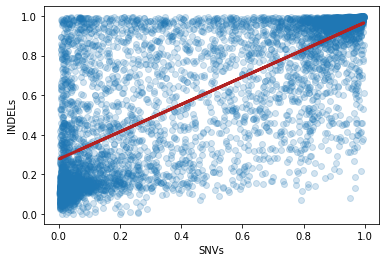

In [150]:
plt.scatter(x,y, alpha = 0.2)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, linewidth = 3, c='firebrick')
plt.xlabel('SNVs')
plt.ylabel('INDELs')
plt.savefig('Same AA change SNV INDEL.pdf')

In [35]:
def calculate_indel(row, anno_file):
     contig, start, _, ref, alt = row
     start = int(start)
     myVariant = Variant(contig=contig, start=start, ref=ref, alt=alt)
     me = myVariant.effects().top_priority_effect()
     Conseq = type(me).__name__
     if Conseq in ['Insertion', 'Substitution', 'Deletion', 'ComplexSubstitution'] and 'protein_coding' in set([x.biotype for x in myVariant.genes]):
          trans_name = me.transcript_id
          l_pos = me.aa_mutation_start_offset
          r_pos = me.aa_mutation_end_offset
          
          if trans_name in anno_file.keys():
               anno = anno_file[trans_name][()]
               anno = anno[(l_pos<=anno[:,-1]) & (anno[:,-1]<=r_pos),:]
               input_instance = np.pad(anno,((0,58-anno.shape[0]),(0,0)))[:,:-1]
               return input_instance
               # score = model(np.expand_dims(input_instance,axis=0)).numpy()[0][0]
               # return ('\t'.join(line)+'\t'+trans_name+'\t'+str(score)+'\n')



In [16]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [147]:
DNA_TO_AA =  {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }
AA_TO_DNA = {}
for k,v in DNA_TO_AA.items():
     if v not in AA_TO_DNA:
          AA_TO_DNA[v] = [k]
     else:
          AA_TO_DNA[v].append(k)

## Publication year and AUROC

In [24]:
"""
Publication year for each score. The versions included in dbNSFP 4.1a were used to retrieve its publication date. 
If no date was available at each score's website, the date of the latest publication was used as publication date.
""" 
year_dict = {"MutationTaster":"2015","FATHMM":"2014","fathmm-XF_coding":"2018","VEST4":"2019","MetaSVM":"2015","MetaLR":"2015","M-CAP":"2018","REVEL":"2016","MutPred":"2016","MVP":"2018","PrimateAI":"2018","DEOGEN2":"2017","BayesDel_addAF":"2016","ClinPred":"2018","LIST-S2":"2019","CADD_raw":"2021","Eigen-raw_coding":"2016","GERP++_RS":"2011","phyloP100way_vertebrate":"2005","phyloP30way_mammalian":"2005","phyloP17way_primate":"2005","phastCons100way_vertebrate":"2005","phastCons30way_mammalian":"2005","phastCons17way_primate":"2005"}

In [29]:
score_dict = {}

for colName, colData in ts.iloc[:,6:-2].iteritems():
     idx = -colData.isna()
     colName = colName.replace('_converted','').replace('_rankscore','')
     roc_score = roc_auc_score(ts.loc[idx, 'label'], colData[idx])
     publication_year = year_dict[colName]
     score_dict[colName] = [round(roc_score, 4)]
     score_dict[colName].append(int(publication_year))

In [30]:
ds = pd.DataFrame.from_dict(score_dict,orient='index', columns=['AUC','Publication Year'])
# correlation
cor_all = ss.pearsonr(ds['AUC'], ds['Publication Year'])[0]
year_2014_idx = ds['Publication Year']>=2014
year_2016_idx = ds['Publication Year']>=2016
cor_2014 = ss.pearsonr(ds.loc[year_2014_idx, 'AUC'], ds.loc[year_2014_idx, 'Publication Year'])[0]
cor_2016 = ss.pearsonr(ds.loc[year_2016_idx, 'AUC'], ds.loc[year_2016_idx, 'Publication Year'])[0]

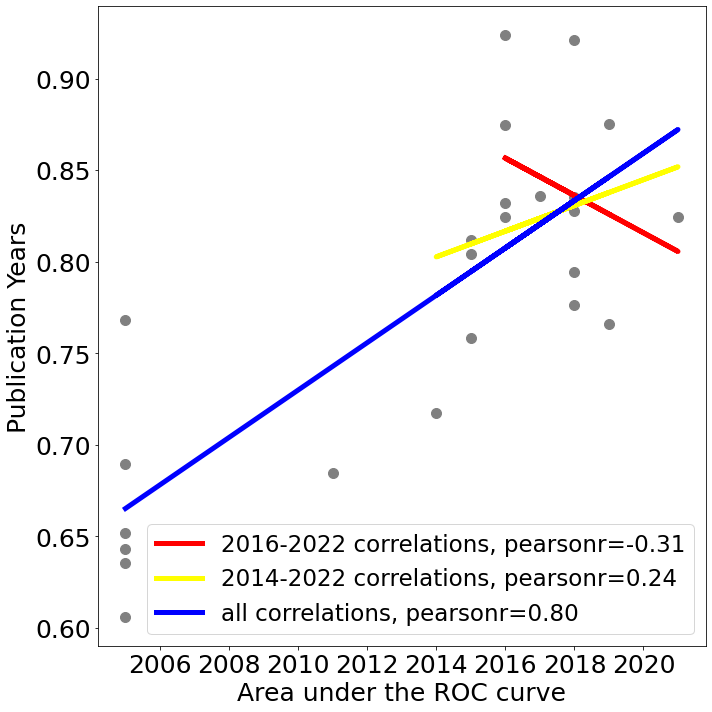

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(ds['Publication Year'],ds['AUC'],color='grey', s=100)
x = ds.loc[year_2016_idx, 'Publication Year']
y = ds.loc[year_2016_idx, 'AUC']
m, b = np.polyfit(x,y, 1)
plt.plot(x, m*x+b, color='red', label= f'2016-2022 correlations, pearsonr={cor_2016:.2f}', linewidth=5)

x = ds.loc[year_2014_idx, 'Publication Year']
y = ds.loc[year_2014_idx, 'AUC']
m, b = np.polyfit(x,y, 1)
plt.plot(x, m*x+b, color='yellow', label=f'2014-2022 correlations, pearsonr={cor_2014:.2f}', linewidth=5)

x = ds['Publication Year']
y = ds['AUC']
m, b = np.polyfit(x,y, 1)
plt.plot(x, m*x+b, color='blue', label=f'all correlations, pearsonr={cor_all:.2f}', linewidth=5)

plt.ylabel('Publication Years', fontsize=25)
plt.xlabel('Area under the ROC curve', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(prop={'size': 23})
plt.tight_layout()

plt.savefig('publication_years.pdf')

## AUC and ROC plot

### main ROCs

In [ ]:
for colName, colData in ts_merged.iloc[:,6:-1].iteritems():
     idx = -colData.isna()
     print(f"{colName}:, {roc_auc_score(ts_merged.loc[idx, 'MetaRNN_label'], colData[idx]):.4f}, {roc_auc_score(ts_merged.loc[idx, 'MetaRNN_label'], ts_merged.loc[idx, 'MetaRNN']):.4f}")

In [37]:
x,y,coord = dataset_to_numpy(ts_valid)
coords = np.array([coord.numpy()[0].decode() for x,y,coord in ts_valid])

[0.9310797947910815, 0.7584157128629735, 0.7175422367613871, 0.8753155154494178, 0.8118424705478282, 0.8040437845075308, 0.8352419910959594, 0.874518620169481, 0.8244298422576686, 0.827803645076432, 0.7761033896237899, 0.8356799544133936, 0.9235148254600616, 0.9209658375149821, 0.7659806053902114, 0.8244496596732732, 0.7944033545960753, 0.8321864306055288, 0.6846546202530139, 0.7681437240158584, 0.6430029413770427, 0.6060662033644835, 0.6894450047210439, 0.6516170213532978, 0.6352825701705134, 1.0]


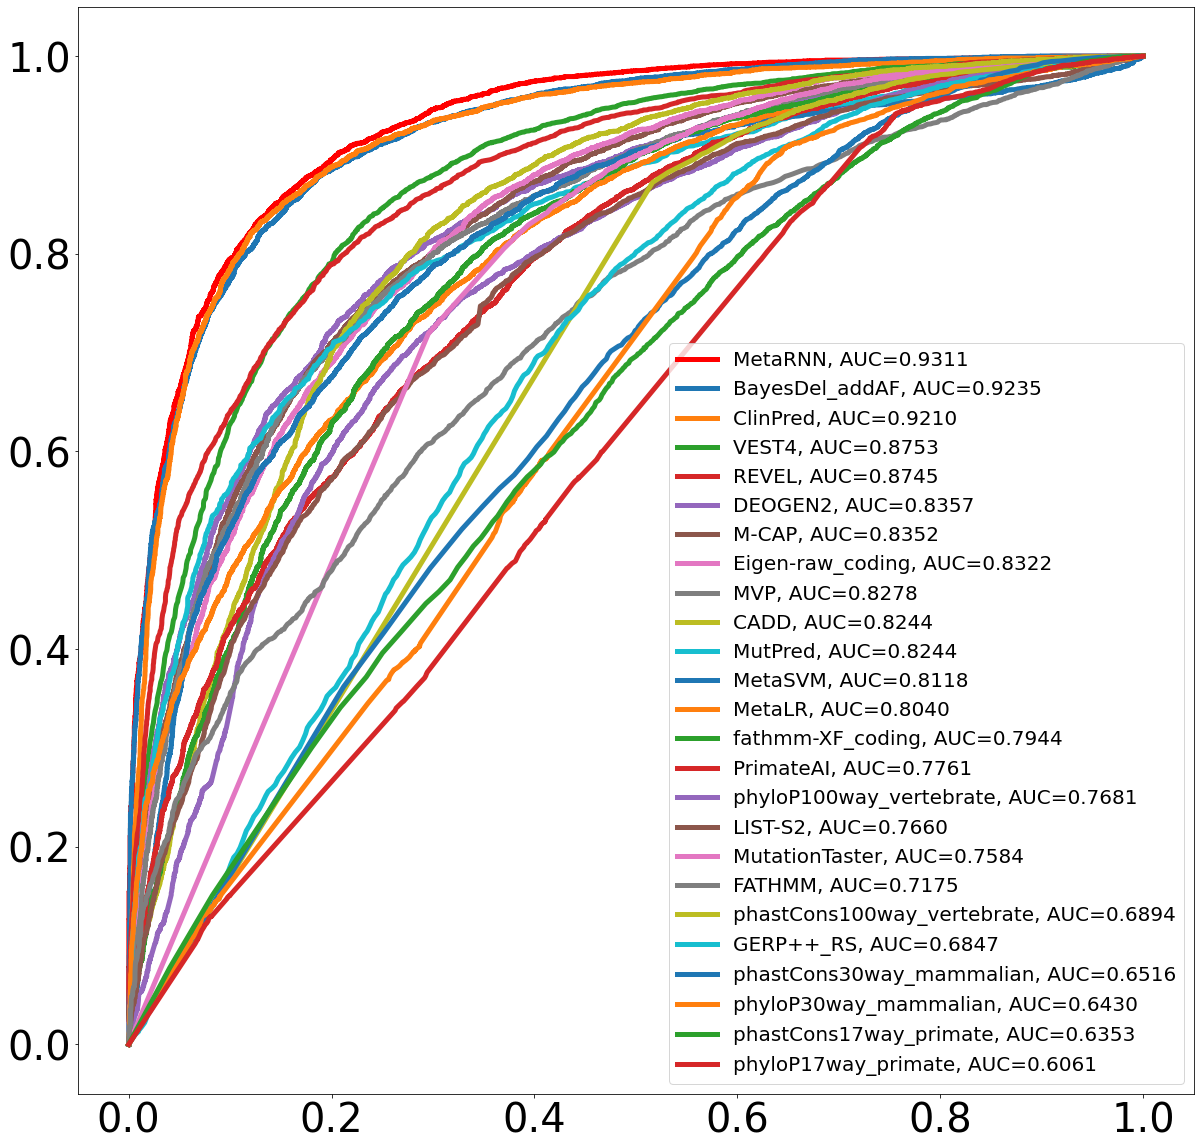

In [279]:
fig1 = ROCPlot(MetaRNN_pred.flatten(),y.flatten(), ts.iloc[:-1], fig_size= (20,20),legend_size=20, linewidth=5)
plt.savefig('New_RNTS_ALL.pdf')

[0.9310797947910815, 0.8753350475299985, 0.8352686337023608, 0.874518620169481, 0.827830286219188, 0.83570671087228, 0.9235281643464479, 0.9209658375149821, 0.8244764499337696]


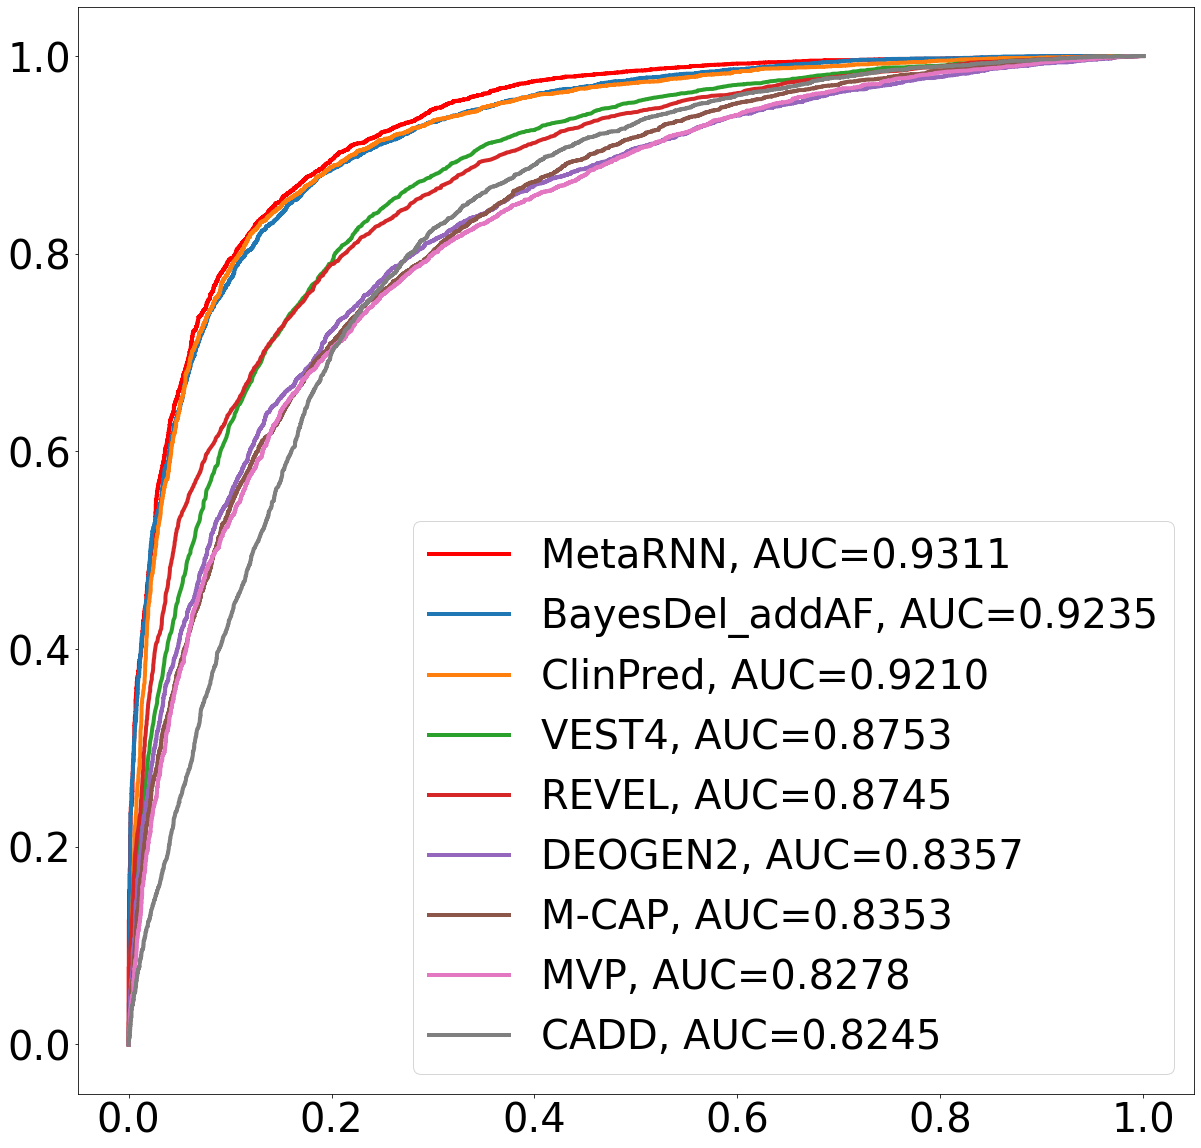

In [269]:
fig1 = ROCPlot(MetaRNN_pred,y, ts.iloc[:,[8,11,12,14,16,17,18,20,-2]], fig_size= (20,20),legend_size=40, with_coord=False, linewidth=4)
plt.savefig('New_RNTS_Key.pdf')

### MetaRNN sensitivity analysis

In [76]:
'''
Compare performance of different MetaRNN setups. MetaRNN, MetaRNN_noAF, MetaRNN_removedAF, MetaRNN_rare, MetaRNN_trainGeneRemoved, MetaRNN_feedforward.
'''
# Use different shapes and colors
ts_matched = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/DNN_adam_control.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])


In [239]:
validation_data = 'valid.matched.5770.5770.coord.tfrecord'
window_size = 11
ts_match = load_test_data(validation_data, window_size=window_size, remove_AF=False, AF_free_model=False)
x, y, coord = dataset_to_numpy(ts_match)
def model_calc(model_path, x):
     model = tf.keras.models.load_model(model_path, compile=False)
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
     MetaRNN_pred = model.predict(x, batch_size = 32)
     MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[z.decode() for z in coord.flatten()]}
     MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)
     MetaRNN_ds['MetaRNN_label'] = MetaRNN_ds['MetaRNN_label'].astype('int32')
     oc = roc_auc_score(MetaRNN_ds['MetaRNN_label'], MetaRNN_ds['MetaRNN'])
     pr = metrics.average_precision_score(MetaRNN_ds['MetaRNN_label'], MetaRNN_ds['MetaRNN'])
     return oc, pr

In [200]:
validation_data = 'valid.nolimit.coord.tfrecord'
window_size = 11
ts_match = load_test_data(validation_data, window_size=window_size, remove_AF=False, AF_free_model=False)
x, y, coord = dataset_to_numpy(ts_match)

def model_calc(model_path, x):
     model = tf.keras.models.load_model(model_path, compile=False)
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
     MetaRNN_pred = model.predict(x, batch_size = 32)
     MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[z.decode() for z in coord.flatten()]}
     MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)
     MetaRNN_ds['MetaRNN_label'] = MetaRNN_ds['MetaRNN_label'].astype('int32')
     oc = roc_auc_score(MetaRNN_ds['MetaRNN_label'], MetaRNN_ds['MetaRNN'])
     pr = metrics.average_precision_score(MetaRNN_ds['MetaRNN_label'], MetaRNN_ds['MetaRNN'])
     return oc, pr

In [238]:
colnames = linecache.getline("dbNSFP_valid.tsv", 1).strip('\n').split('\t')
tp_df = pd.read_csv('valid_tp_match_ds_5770_105', sep='\t', header=None)
tn_df = pd.read_csv('valid_tn_single_ds_5770_105', sep='\t', header=None)
tp_content  = pd.DataFrame(tp_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tp_content['label'] = 1
tn_content  = pd.DataFrame(tn_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tn_content['label'] = 0
ts = pd.concat([tp_content, tn_content])
ts['pos(1-based)'].astype('int64',copy=False)
ts.replace('.',np.NaN, inplace=True)
ts = ts.astype({'pos(1-based)':'int64'})
ts_sorted = ts.sort_values(by=['#chr','pos(1-based)'])
ts["key"] = ts['#chr'].astype('str')+'_'+ts['pos(1-based)'].astype('str')+'_'+ts['ref'].astype('str')+'_'+ts['alt'].astype('str')+'_'+ts['aaref'].astype('str')+'_'+ts['aaalt'].astype('str')
linecache.clearcache()





In [229]:
oc, pr = model_calc('models/RNN_DNN_adam.h5', x)

In [230]:
FFoc, FFpr = model_calc('models/DNN_adam.h5', x)

In [231]:
Rare_oc, Rare_pr = model_calc('models/RNN_DNN_adam_rare.h5', x)

In [233]:
oc_noAF, pr_noAF = model_calc('models/RNN_DNN_adam.h5', x)

In [234]:
FFoc_noAF, FFpr_noAF = model_calc('models/DNN_adam.h5', x)

In [235]:
Rare_oc_noAF, Rare_pr_noAF = model_calc('models/RNN_DNN_adam_rare.h5', x)

In [237]:
AFfree_oc, AFfree_pr = model_calc('models/RNN_DNN_adam_noAF.h5', x)

In [182]:
ts_nolimit = load_test_data('valid.newgene.tfrecord', remove_AF = True).batch(32)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
# model.evaluate(ts_nolimit)
MetaRNN_pred = model.predict(ts_nolimit)
label = [x[1].numpy() for x in load_test_data('valid.newgene.tfrecord', remove_AF = False)]


In [181]:
New_oc = metrics.roc_auc_score(label, MetaRNN_pred)
New_pr = metrics.average_precision_score(label, MetaRNN_pred)


In [183]:
New_oc_noAF = metrics.roc_auc_score(label, MetaRNN_pred)
New_pr_noAF = metrics.average_precision_score(label, MetaRNN_pred)

In [240]:
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])

MetaRNN_pred = model.predict(x, batch_size = 32)
MetaRNN_dict = {'MetaRNN':MetaRNN_pred.flatten(), 'MetaRNN_label':y.flatten(), 'key':[x.decode() for x in coord.flatten()]}
MetaRNN_ds = pd.DataFrame.from_dict(MetaRNN_dict)
ts_merged = ts.merge(MetaRNN_ds, on='key')
ts_merged = ts_merged.drop(['key','label'], axis=1)
# ts_merged['MetaRNN_label'] = ts_merged['MetaRNN_label'].astype('int32')


In [241]:
idx = - ts_merged['CADD_raw_rankscore'].isna()
CADD_oc = metrics.roc_auc_score(ts_merged.MetaRNN_label[idx], ts_merged.CADD_raw_rankscore[idx])
CADD_pr = metrics.average_precision_score(ts_merged.MetaRNN_label[idx].astype('int'), ts_merged.CADD_raw_rankscore[idx].astype('float'))

In [222]:
def plot_scatter(oc, pr, label, s=200, alpha=0.7):
     plt.scatter(oc, pr, label=label, s=s, alpha=alpha)

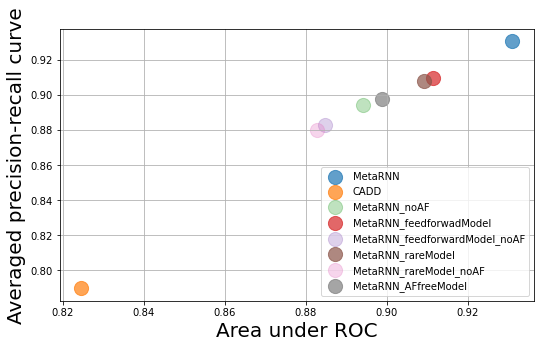

In [242]:
plt.rcParams["figure.figsize"] = [8.5, 5]
plt.grid()
plot_scatter(oc, pr, 'MetaRNN')
plot_scatter(CADD_oc, CADD_pr, 'CADD')
plot_scatter(oc_noAF, pr_noAF, 'MetaRNN_noAF', alpha=0.3)
plot_scatter(FFoc, FFpr, 'MetaRNN_feedforwadModel')
plot_scatter(FFoc_noAF, FFpr_noAF, 'MetaRNN_feedforwardModel_noAF', alpha=0.3)
plot_scatter(Rare_oc, Rare_pr, 'MetaRNN_rareModel')
plot_scatter(Rare_oc_noAF, Rare_pr_noAF, 'MetaRNN_rareModel_noAF', alpha=0.3)
plot_scatter(AFfree_oc, AFfree_pr, 'MetaRNN_AFfreeModel')
# plot_scatter(New_oc, New_pr, 'MetaRNN_UnseenGenes')

# plot_scatter(New_oc_noAF, New_pr_noAF, 'MetaRNN_UnseenGenes_noAF')
plt.tight_layout
plt.legend(loc='lower right')
plt.xlabel('Area under ROC', fontsize=20)
plt.ylabel('Averaged precision-recall curve', fontsize=20)
plt.savefig('MetaRNN.matchedvar.performance.pdf')


## Create unique genes for validation using the whole validation set AAFS.

In [114]:
tp_df = pd.read_csv('train_tp_ds_30096_105', sep='\t', header=None, low_memory=False)
tn_df = pd.read_csv('train_tn_ds_21536_105', sep='\t', header=None, low_memory=False)
tp_genes = tp_df[7].values.tolist()
tp_genes = [y for x in tp_genes for y in x.split(';')]

tn_genes = tn_df[7].values.tolist()
tn_genes = [y for x in tn_genes for y in x.split(';')]

train_genes = set(tp_genes+tn_genes)
print(len(train_genes))

4255


In [291]:
tp_df = pd.read_csv('valid_tp_ds_6291_105', sep='\t', header=None)
tn_df = pd.read_csv('valid_tn_ds_23633_105', sep='\t', header=None)
tp_gene_idx = tp_df[7].apply(lambda x: set([0 if y in train_genes else 1 for y in x.split(';')]))=={1}
tn_gene_idx = tn_df[7].apply(lambda x: set([0 if y in train_genes else 1 for y in x.split(';')]))=={1}
# def write_to_csv(df,out_name):
#     df.iloc[:,:-1].to_csv(f'{out_name}_{df.shape[0]}_{df.shape[1]}',header=False,sep='\t', index=False)
# write_to_csv(tp_df[tp_gene_idx], 'valid_tp_ds_newgenes')
# write_to_csv(tn_df[tn_gene_idx], 'valid_tn_ds_newgenes')

tp_genes  = tp_df[tp_gene_idx][7].values.tolist()
tp_genes = [y for x in tp_genes for y in x.split(';')]
tn_genes = tn_df[tn_gene_idx][7].values.tolist()
tn_genes = [y for x in tn_genes for y in x.split(';')]

uniq_genes = set(tp_genes+tn_genes)
print(len(uniq_genes))

3971


In [292]:
ts_nolimit = load_test_data('valid.newgene.tfrecord', remove_AF = True).batch(32)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
# model.evaluate(ts_nolimit)
MetaRNN_pred = model.predict(ts_nolimit)
label = [x[1].numpy() for x in load_test_data('valid.newgene.tfrecord', remove_AF = False)]

In [ ]:
ts_nolimit = load_test_data('valid.newgene.tfrecord', remove_AF = True).batch(32)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
# model.evaluate(ts_nolimit)
MetaRNN_pred = model.predict(ts_nolimit)
label = [x[1].numpy() for x in load_test_data('valid.newgene.tfrecord', remove_AF = False)]

In [312]:
filename = 'valid_clinvar_new.rare.tfrecord'
ts_nolimit = load_test_data(f'TFrecords/{filename}', remove_AF = False)
x,y,coord = dataset_to_numpy(ts_nolimit)

## RCTS DN-RCTS performance analysis

In [66]:
tp_df1 = pd.read_csv('valid_tp_0_0.001_6151_105', sep='\t', header=None)
tp_df1 = tp_df1[tp_df1[1]!='M']
tn_df1 = pd.read_csv('valid_tn_0_0.001_4045_105', sep='\t', header=None)
tn_df1 = tn_df1[tn_df1[1]!='M']

In [67]:
tp_df = pd.read_csv('valid_tp_0.001_0.01_125_105', sep='\t', header=None)
tp_df = tp_df[tp_df[1]!='M']
tn_df = pd.read_csv('valid_tn_0.001_0.01_8591_105', sep='\t', header=None)
tn_df = tn_df[tn_df[1]!='M']

In [185]:
tp_df = pd.read_csv('valid_tp_0_0_4623_105', sep='\t', header=None)
tp_df = tp_df[tp_df[1]!='M']
tn_df = pd.read_csv('valid_tn_0_0_1656_105', sep='\t', header=None)
tn_df = tn_df[tn_df[1]!='M']

In [242]:
tp_df = pd.read_csv('valid_tp_match_ds_5770_105', sep='\t', header=None)
tp_df = tp_df[tp_df[1]!='M']
tn_df = pd.read_csv('valid_tn_single_ds_5770_105', sep='\t', header=None)
tn_df = tn_df[tn_df[1]!='M']

In [68]:
tp_df = pd.concat([tp_df1, tp_df])
tn_df = pd.concat([tn_df1, tn_df])

In [11]:
tp_df = pd.read_csv('valid_tp_0.01_0.1_13_105', sep='\t', header=None)
tp_df = tp_df[tp_df[1]!='M']
tn_df = pd.read_csv('valid_tn_0.01_0.1_10211_105', sep='\t', header=None)
tn_df = tn_df[tn_df[1]!='M']

In [243]:
tp_content  = pd.DataFrame(tp_df.iloc[:,0].apply(lambda x:linecache.getline("MetaRNN_preds/All_MetaRNN_pred", x+1).strip('\n').split('\t')).to_list())
tp_content['label'] = 1
tp_idx = -(tp_content[0]=="")
tp_content = tp_content[tp_idx]

tn_content  = pd.DataFrame(tn_df.iloc[:,0].apply(lambda x:linecache.getline("MetaRNN_preds/All_MetaRNN_pred", x+1).strip('\n').split('\t')).to_list())
tn_content['label'] = 0
tn_idx = -(tn_content[0]=="")
tn_content = tn_content[tn_idx]
ts_metarnn = pd.concat([tp_content, tn_content])

ts_metarnn['MetaRNN'] = ts_metarnn[4].apply(lambda x: float(x.split(';')[0]))
# ts_sorted = ts.sort_values(by=['#chr','pos(1-based)'])
# ts["key"] = ts['#chr'].astype('str')+'_'+ts['pos(1-based)'].astype('str')+'_'+ts['ref'].astype('str')+'_'+ts['alt'].astype('str')+'_'+ts['aaref'].astype('str')+'_'+ts['aaalt'].astype('str')
linecache.clearcache()

In [244]:
colnames = linecache.getline("dbNSFP_valid.tsv", 1).strip('\n').split('\t')
tp_content  = pd.DataFrame(tp_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tp_content['label'] = 1
tn_content  = pd.DataFrame(tn_df.iloc[:,0].apply(lambda x:linecache.getline("dbNSFP_valid.tsv", x+2).strip('\n').split('\t')).to_list(), 
                         columns = colnames)
tn_content['label'] = 0
ts = pd.concat([tp_content, tn_content])
ts['pos(1-based)'].astype('int64',copy=False)
ts.replace('.',np.NaN, inplace=True)
ts = ts.astype({'pos(1-based)':'int64'})
ts_sorted = ts.sort_values(by=['#chr','pos(1-based)'])
ts["key"] = ts['#chr'].astype('str')+'_'+ts['pos(1-based)'].astype('str')+'_'+ts['ref'].astype('str')+'_'+ts['alt'].astype('str')+'_'+ts['aaref'].astype('str')+'_'+ts['aaalt'].astype('str')
linecache.clearcache()

In [245]:
ts_merged = pd.concat([ts, ts_metarnn['MetaRNN']], axis=1)

In [198]:
p,r,t = metrics.precision_recall_curve(ts_merged['label'], ts_merged['MetaRNN'])
idx = - (ts_merged['ClinPred_rankscore'].isna())
pc, rc, tc = metrics.precision_recall_curve(ts_merged.loc[idx, 'label'], ts_merged.loc[idx, 'ClinPred_rankscore'].astype('float'))

In [235]:
m(ts_merged['label'], ts_merged['MetaRNN'])

<tf.Tensor: shape=(), dtype=float32, numpy=0.69193745>

In [246]:
for colname, coldata in ts_merged.iloc[:,6:].iteritems():
     idx = - (coldata.isna())
     try:
          m = tf.keras.metrics.SpecificityAtSensitivity(0.95, num_thresholds=10000)
          print(colname, m(ts_merged.loc[idx, 'label'], ts_merged.loc[idx, colname].astype('float')).numpy())
     except:
          continue

MutationTaster_converted_rankscore 0.37105817
FATHMM_converted_rankscore 0.15956242
VEST4_rankscore 0.51622576
MetaSVM_rankscore 0.26816332
MetaLR_rankscore 0.32260916
M-CAP_rankscore 0.40776184
REVEL_rankscore 0.46791586
MutPred_rankscore 0.29972857
MVP_rankscore 0.369588
PrimateAI_rankscore 0.31434995
DEOGEN2_rankscore 0.3570348
BayesDel_addAF_rankscore 0.64039063
ClinPred_rankscore 0.642958
LIST-S2_rankscore 0.2818379
CADD_raw_rankscore 0.4426343
fathmm-XF_coding_rankscore 0.3467742
Eigen-raw_coding_rankscore 0.41062525
GERP++_RS_rankscore 0.26770833
phyloP100way_vertebrate_rankscore 0.27885616
phyloP30way_mammalian_rankscore 0.23535529
phyloP17way_primate_rankscore 0.2187175
phastCons100way_vertebrate_rankscore 0.32599655
phastCons30way_mammalian_rankscore 0.22461005
phastCons17way_primate_rankscore 0.18700173
label 1.0
MetaRNN 0.68769497


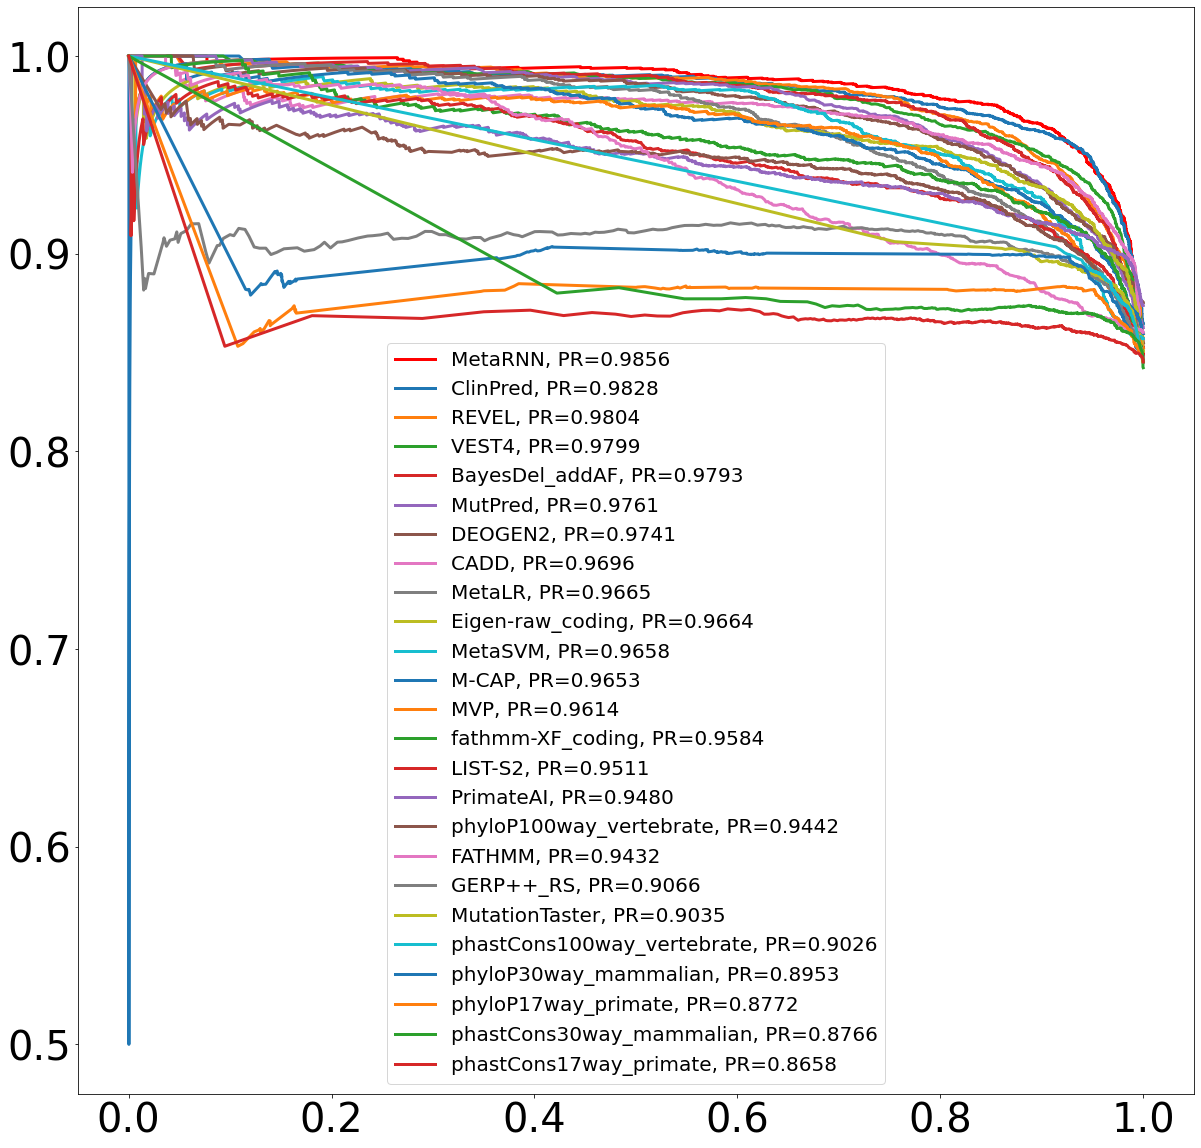

In [210]:
f = PRCPlot(ts_merged['MetaRNN'], ts_merged['label'], ts_merged.iloc[:,:-3], linewidth=3, legend_size=20)
plt.savefig('DN-RCTS_PRC.pdf')

In [188]:
ts_merged = pd.concat([ts, ts_metarnn['MetaRNN']], axis=1)

In [189]:
ts_merged.iloc[:,[0,1,2,3,4,5,-3]].to_csv('DN-RCTS.tsv',sep='\t',index=False)

In [132]:
for colName, colData in ts_merged.iloc[:,6:-2].iteritems():
     idx = -colData.isna()
     print(f"{sum(idx)},{colName}:, {metrics.average_precision_score(ts_merged.loc[idx, 'label'].to_numpy(), [float(x) for x in colData[idx].to_numpy()]):.4f}")
     print(metrics.average_precision_score(ts_merged.loc[idx, 'label'].to_numpy(), ts_merged.loc[idx, 'MetaRNN'].to_numpy()))

5345,MutationTaster_converted_rankscore:, 0.9035
0.9857093072678027
5028,FATHMM_converted_rankscore:, 0.9432
0.9865979466101849
5255,VEST4_rankscore:, 0.9799
0.9857529936236091
5223,MetaSVM_rankscore:, 0.9658
0.9859895299041243
5223,MetaLR_rankscore:, 0.9665
0.9859895299041243
5210,M-CAP_rankscore:, 0.9653
0.9860656454784865
5223,REVEL_rankscore:, 0.9804
0.9859895299041243
5056,MutPred_rankscore:, 0.9761
0.9861146166910575
5300,MVP_rankscore:, 0.9614
0.9857888021806053
4922,PrimateAI_rankscore:, 0.9480
0.9873330002337896
4768,DEOGEN2_rankscore:, 0.9741
0.9869257602789352
5320,BayesDel_addAF_rankscore:, 0.9793
0.9857530278985656
5247,ClinPred_rankscore:, 0.9828
0.9859559261472546
5115,LIST-S2_rankscore:, 0.9511
0.9859156997648081
5368,CADD_raw_rankscore:, 0.9696
0.9856083039058009
4705,fathmm-XF_coding_rankscore:, 0.9584
0.9842626044644158
4698,Eigen-raw_coding_rankscore:, 0.9664
0.9844584195509515
5356,GERP++_RS_rankscore:, 0.9066
0.9856893194344097
5368,phyloP100way_vertebrate_ranksco

In [133]:
for colName, colData in ts_merged.iloc[:,6:-2].iteritems():
     idx = -colData.isna()
     print(f"{sum(idx)},{colName}:, {roc_auc_score(ts_merged.loc[idx, 'label'].to_numpy(), [float(x) for x in colData[idx].to_numpy()]):.4f}")
     print(roc_auc_score(ts_merged.loc[idx, 'label'].to_numpy(), ts_merged.loc[idx, 'MetaRNN'].to_numpy()))

5345,MutationTaster_converted_rankscore:, 0.6982
0.9335655572025334
5028,FATHMM_converted_rankscore:, 0.7327
0.9312482062829769
5255,VEST4_rankscore:, 0.9047
0.9301512979773849
5223,MetaSVM_rankscore:, 0.8486
0.9295957936247126
5223,MetaLR_rankscore:, 0.8373
0.9295957936247126
5210,M-CAP_rankscore:, 0.8405
0.92904140590076
5223,REVEL_rankscore:, 0.9037
0.9295957936247126
5056,MutPred_rankscore:, 0.8755
0.9275553539228033
5300,MVP_rankscore:, 0.8400
0.9311399604128631
4922,PrimateAI_rankscore:, 0.7602
0.9260166144129229
4768,DEOGEN2_rankscore:, 0.8538
0.9250004530928115
5320,BayesDel_addAF_rankscore:, 0.9008
0.9309976170794381
5247,ClinPred_rankscore:, 0.9179
0.9290400118994497
5115,LIST-S2_rankscore:, 0.8072
0.933991364268181
5368,CADD_raw_rankscore:, 0.8865
0.9337064653854242
4705,fathmm-XF_coding_rankscore:, 0.8380
0.9306438417361445
4698,Eigen-raw_coding_rankscore:, 0.8638
0.9269853875308014
5356,GERP++_RS_rankscore:, 0.7102
0.9334060299712482
5368,phyloP100way_vertebrate_rankscore:

In [45]:
metrics.average_precision_score(ts_merged['label'], ts_merged['MetaRNN'])

0.957166404807293

idx = -colData.isna()
     print(f"{sum(idx)},{colName}:, {metrics.average_precision_score(ts_merged.loc[idx, 'label'].to_numpy(), [float(x) for x in colData[idx].to_numpy()]):.4f}")
     print(metrics.average_precision_score(ts_merged.loc[idx, 'label'].to_numpy(), ts_merged.loc[idx, 'MetaRNN'].to_numpy()))

In [71]:
AUCs = []
PRs = []
Names = []
for colName, colData in ts_merged.iloc[:,6:-3].iteritems():
     idx = -colData.isna()
     PRs.append(round(metrics.average_precision_score(ts_merged.loc[idx, 'label'].to_numpy(), colData[idx].astype('float')),4))
     AUCs.append(round(roc_auc_score(ts_merged.loc[idx, 'label'].to_numpy(), colData[idx]),4))
     Names.append(colName.replace('_rankscore','').replace('_raw','').replace('_converted',''))
PRs.append(round(metrics.average_precision_score(ts_merged['label'], ts_merged['MetaRNN']), 4))
AUCs.append(round(roc_auc_score(ts_merged['label'], ts_merged['MetaRNN']), 4))
Names.append('MetaRNN')

In [90]:
import seaborn as sns
c = sns.color_palette("pastel",n_colors = len(Names)-1)
c.append('red')

In [111]:
index = ss.rankdata(AUCs)
index = len(AUCs) - index   # Reverse rank so the highest AUC shows at the begninning
index = [int(x) for x in index]

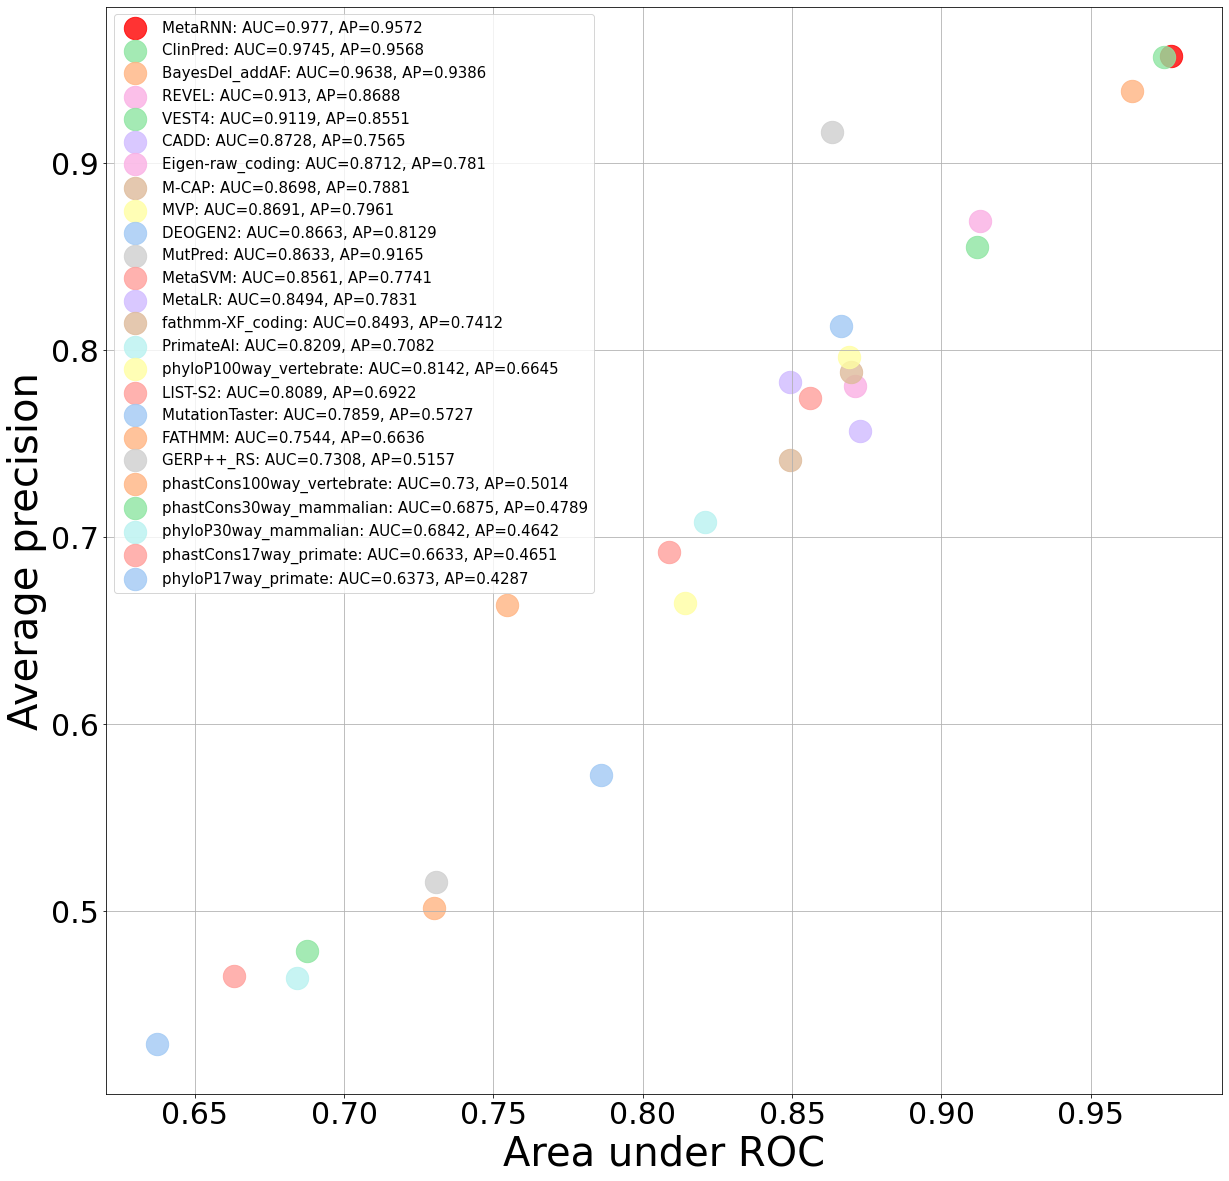

In [127]:
plt.figure(figsize=(20,20))
plt.grid()
for i in range(len(index)):
     new_index = index.index(i)
     plt.scatter(AUCs[new_index], PRs[new_index], color=c[new_index], s=500, label=f'{Names[new_index]}: AUC={AUCs[new_index]}, AP={PRs[new_index]}',alpha=0.8)
plt.legend(fontsize=15, loc='best')
plt.xlabel('Area under ROC', fontsize=40)
plt.xticks(fontsize=30)
plt.ylabel('Average precision', fontsize=40)
plt.yticks(fontsize=30)
plt.savefig('RCTS_0_0.01.pdf')

[0.9337064653854242, 0.9046770620683665, 0.8404941716390353, 0.9037046276103128, 0.8399744502539722, 0.853837293364506, 0.9007756475105194, 0.9178862115127174, 0.886516453696535, 0.9337064653854242]


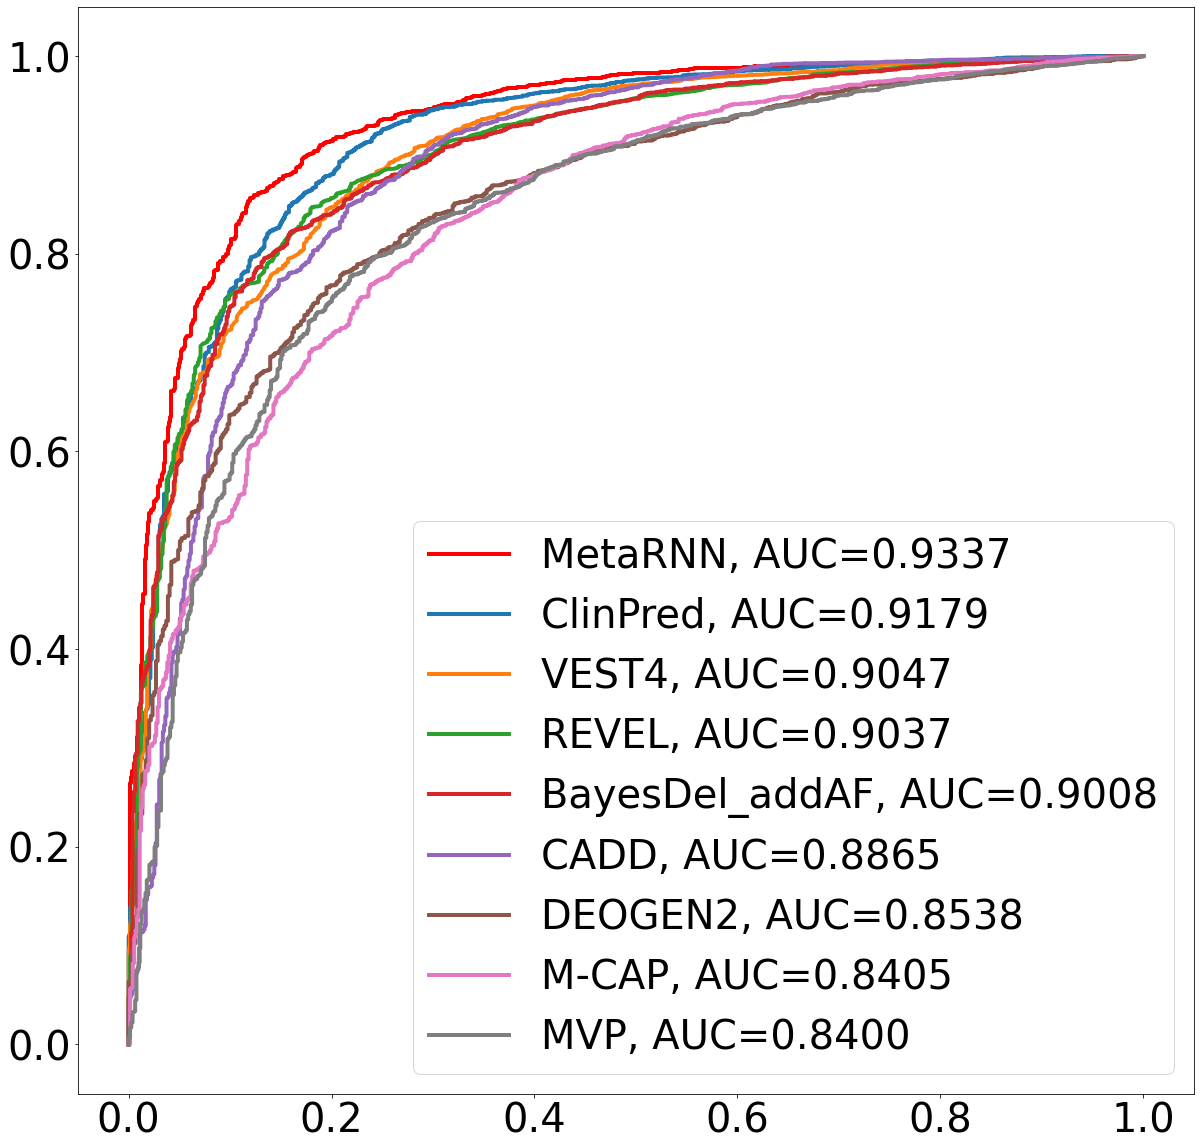

In [147]:
fig1 = ROCPlot(ts_merged['MetaRNN'],ts_merged['label'], ts_merged.iloc[:,[8,11,12,14,16,17,18,20,-1,-3]], fig_size= (20,20),legend_size=40, with_coord=False, linewidth=4)
plt.savefig('DENOVO_RCTS_Key.pdf')

[0.9337064653854242, 0.6981943134348471, 0.7327238266655758, 0.9046770620683665, 0.848591700773758, 0.8372749678845636, 0.8404941716390353, 0.9037046276103128, 0.8754731226998989, 0.8399744502539722, 0.7602454861838414, 0.853837293364506, 0.9007756475105194, 0.9178862115127174, 0.8072463253778134, 0.886516453696535, 0.8379962229063841, 0.8638084775445594, 0.7102028209339459, 0.8018617878351206, 0.6826729124113088, 0.6268133095789215, 0.7001623501059745, 0.6075771693472602, 0.5763309406518989]


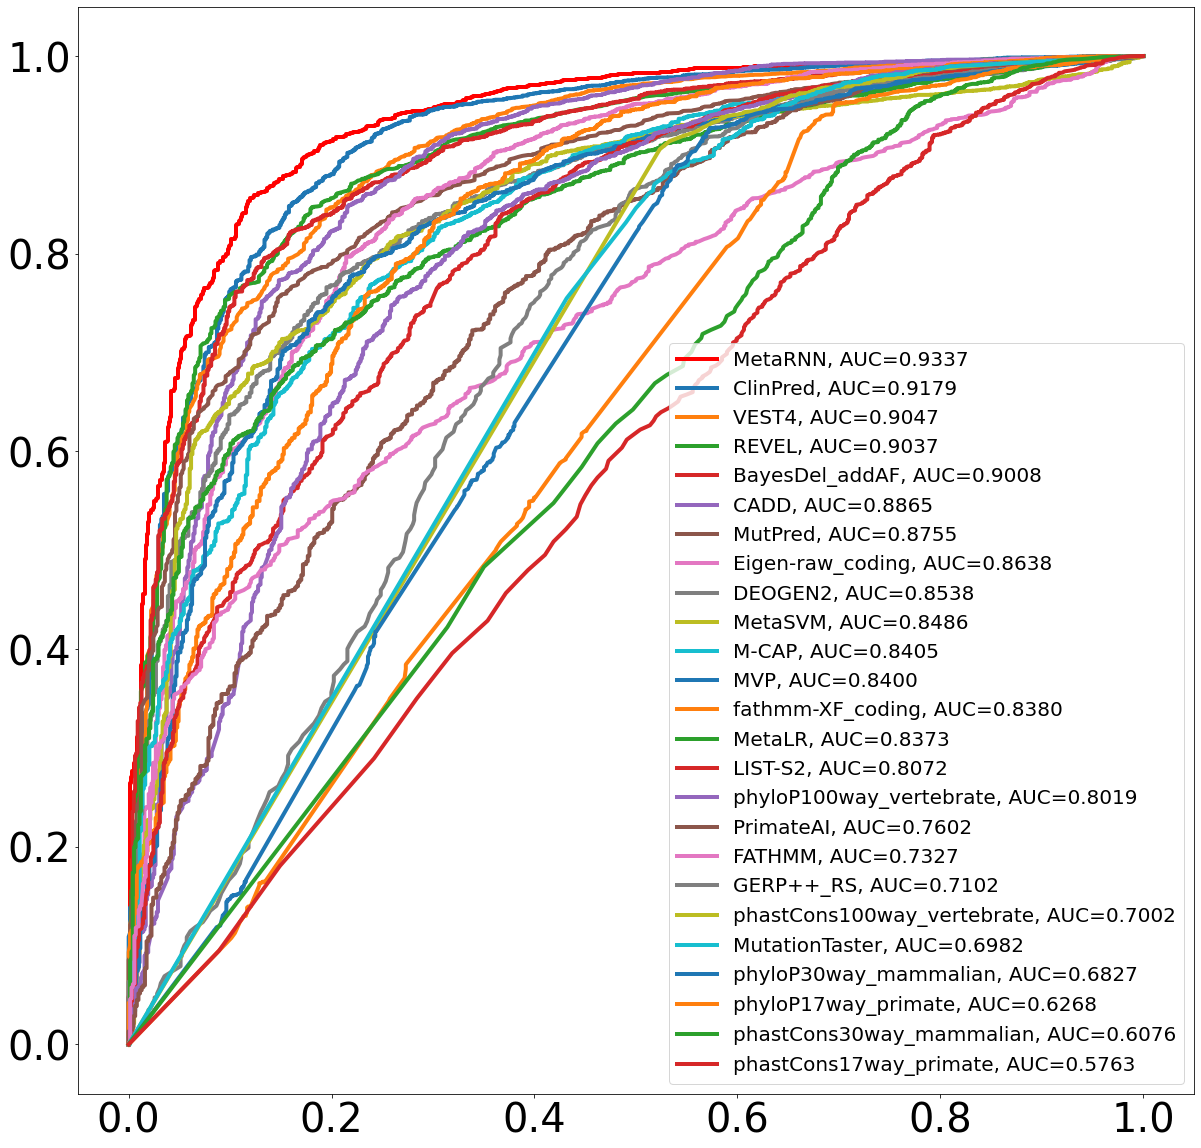

In [156]:
fig1 = ROCPlot(ts_merged['MetaRNN'],ts_merged['label'], ts_merged.iloc[:,:-2], fig_size= (20,20),legend_size=20, with_coord=True, linewidth=4)
plt.savefig('DENOVO_RCTS_All.pdf')

## Combined MetaRNN and MetaRNN-indel analysis

In [ ]:
ts_matched = load_test_data('valid.matched.5770.5770.coord.tfrecord', remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
x, MetaRNN_y, MetaRNN_coord = dataset_to_numpy(ts_matched)
selected_idx = np.random.choice(range(x.shape[0]-1), 828)
MetaRNN_pred = model.predict(x[selected_idx]).flatten()
ts_indel = load_test_data('valid.indel.coord.tfrecord', window_size=58, remove_AF = False)
model = tf.keras.models.load_model('models/RNN_DNN_indel_adam.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
x, MetaRNN_indel_y, MetaRNN_indel_coord = dataset_to_numpy(ts_indel)
# selected_idx = np.random.choice(range(x.shape[0]-1), 1000)
MetaRNN_indel_pred = model.predict(x).flatten()
all_pred = np.concatenate([MetaRNN_pred, MetaRNN_indel_pred])
all_y = np.concatenate([MetaRNN_y[selected_idx], MetaRNN_indel_y]).flatten()

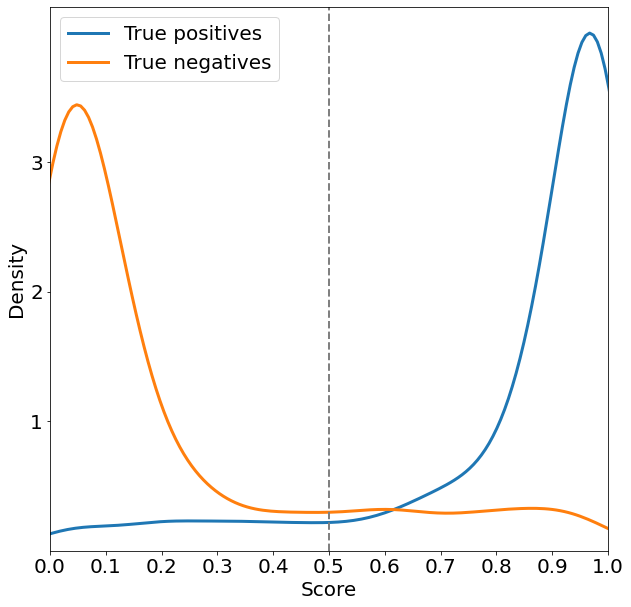

In [84]:
plt.figure(figsize=(10,10))
sns.distplot(all_pred[all_y==1], hist = False, kde = True,
             bins=30,kde_kws = {'linewidth': 3},
                 label = 'True positives')

sns.distplot(all_pred[all_y==0], hist = False, kde = True,
             bins=30,kde_kws = {'linewidth': 3},
                 label = 'True negatives')

plt.xlim(0, 1)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize=20)
plt.yticks([1,2,3],fontsize=20)
plt.axvline(x=0.5,linewidth = 2, color='grey',linestyle='--')
plt.xlabel('Score',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('combined_scores_dist.pdf')

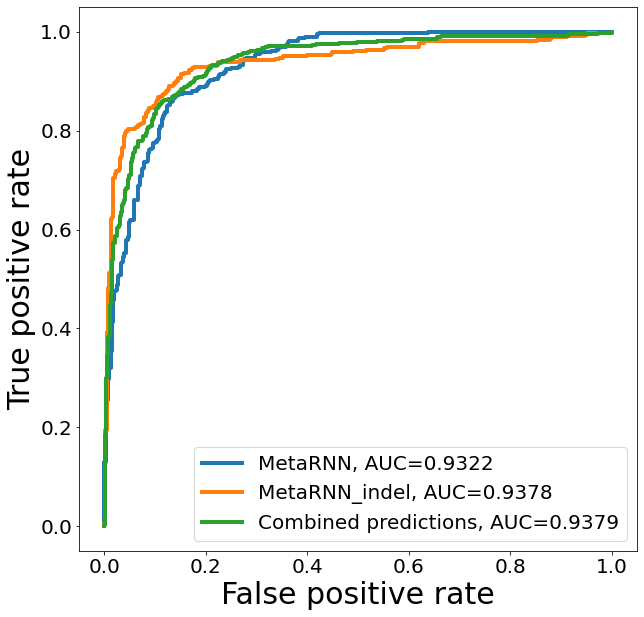

In [85]:
fpr_metarnn,tpr_metarnn,_ = metrics.roc_curve(MetaRNN_y[selected_idx],MetaRNN_pred)
auc_metarnn = roc_auc_score(MetaRNN_y[selected_idx],MetaRNN_pred)

fpr_indel,tpr_indel,_ = metrics.roc_curve(MetaRNN_indel_y,MetaRNN_indel_pred)
auc_indel = roc_auc_score(MetaRNN_indel_y,MetaRNN_indel_pred)

fpr_all,tpr_all,_ = metrics.roc_curve(all_y,all_pred)
auc_all = roc_auc_score(all_y,all_pred)
plt.figure(figsize=(10,10))

plt.plot(fpr_metarnn, tpr_metarnn, label=f'MetaRNN, AUC={auc_metarnn:.4f}', linewidth=4)
plt.plot(fpr_indel, tpr_indel, label=f'MetaRNN_indel, AUC={auc_indel:.4f}', linewidth=4)
plt.plot(fpr_all, tpr_all, label=f'Combined predictions, AUC={auc_all:.4f}', linewidth=4)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.xlabel('False positive rate', fontsize=30)
plt.ylabel('True positive rate', fontsize=30)
plt.tight_layout

plt.savefig('combined_scores_AUCs.pdf')